# Import Packages

In [4]:
! jupyter kernelspec list

Available kernels:
  python3    /Library/Frameworks/Python.framework/Versions/3.6/share/jupyter/kernels/python3


In [8]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

#word count
from collections import Counter

#word clouds
import heapq
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import collections
import matplotlib.cm as cm
from matplotlib import rcParams
from tqdm import tqdm

#sentiment analysis
from textblob import TextBlob

#text preprocessing
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('wordnet')

#hide warning
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed
[nltk_data]     (_ssl.c:833)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed
[nltk_data]     (_ssl.c:833)>


In [58]:
# Topic modeling
# spacy for lemmatization
import spacy;
import en_core_web_sm
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

New York City, New York  (New York county 103208 1st)  
Boston, Massachusetts  (Suffolk county 20934 20th)    
Chicago, Illinois  (Cook county 14585 5th)  
Detroit, Michigan  (Wayne county 11164 6th)  
Los Angeles, California  (Los Angeles county 8894 8th)  
Houston, Texas  (Harris county 3747 26th)  
Newark, New Jersey  (Essex county 7410 11th)  
Miami, Florida  (Miami-dade county 7058 12th)  
Philadelphia, Pennsylvania  (Philadelphia county 6386 13th)  
New Orleans, Louisiana	(Orleans county 5600 17th)  

# Explore Data

In [30]:
# read file
df = pd.read_csv("StayHome_final.csv")

In [31]:
# drop duplicate rows
df.drop_duplicates(inplace =True)
df.drop_duplicates(subset = ['Text'],inplace =True)

In [32]:
df.head()

,User,Text,Retweets,Favorites,HashTags,City,date,time
0,BalloonSaloon,Thankfully there is still always much to celeb...,0,0,#memories #coronapocalypse #nyc #coronavirus #...,New York,2020-04-11,23-54-18
1,Andros1975,When you want a hot pocket and you are not all...,0,0,#HomeMade #HotPockets #StayHome #StayHome #Sta...,New York,2020-04-11,23-45-03
2,Blackjadedwolf,Miss #baseball... Miss my @yankees ... Miss w...,0,0,#baseball #gypsyqueen #autograph #stayhome #st...,New York,2020-04-11,23-27-21
3,tamifoxspeaker,Making the best of it! Took one room with a vi...,0,7,#stayca #staycation #StayHome #StayHome #Quare...,New York,2020-04-11,23-25-03
4,davidagnino,Day 20 of the self isolation playing #TheSims4...,0,0,#TheSims4 #TheSims4 #PS4 #StaySafe #StayHome #...,New York,2020-04-11,23-24-28


In [12]:
print('shape:', df.shape)
print('number of tweets:', df['Text'].nunique())
print('number of users:', df['User'].nunique())

print("range:", df['date'].min(),",", df['date'].max())
print("dates:",df['date'].nunique())

shape: (11631, 8)
number of tweets: 11631
number of users: 6741
range: 2020-03-05 , 2020-04-11
dates: 36


In [6]:
# get information about the number of missing values and their percentage
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
missing_values_table(df)

Your selected dataframe has 8 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
HashTags,6,0.1


# Exploratory Data Analysis

Text(0.5, 1.0, 'Number of Tweets per day')

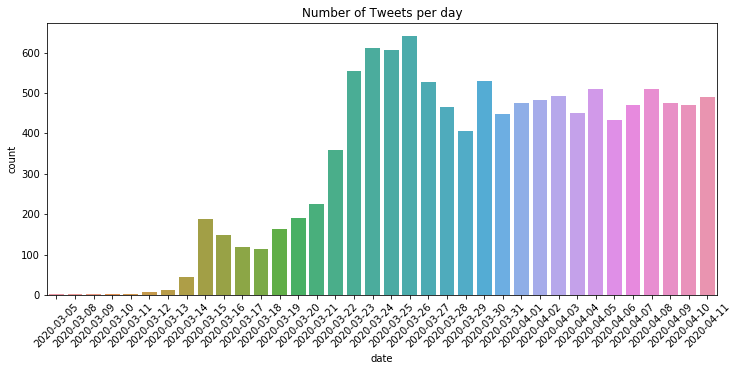

In [14]:
# plot number of tweets everyday
fig = plt.figure(figsize = (12,5))
chart = sns.countplot(df['date'], order = sorted(df['date'].unique()))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_title('Number of Tweets per day')

In [15]:
# dates = sorted(df['date'].unique())
# fig= plt.figure(figsize=(12,4))
# chart = sns.countplot(df.groupby(['User'])['date'].min(), order = dates)
# chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
# chart.set_title('Number of Users per day')

Text(0.5, 1.0, 'Number of Tweets in Different Cities Groups across Dates')

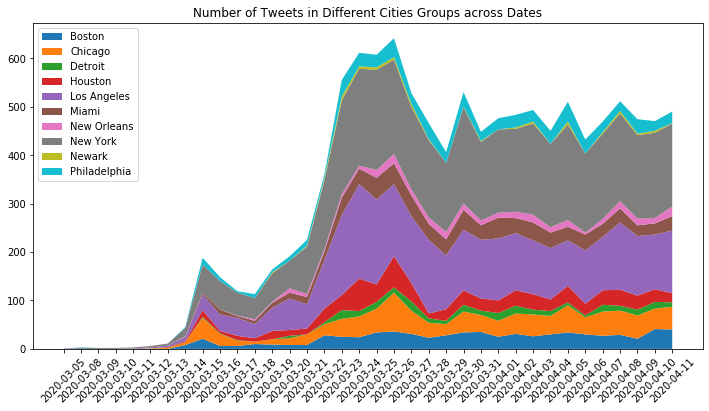

In [16]:
# plot number of tweets everyday in each city 
pivot = pd.pivot_table(df, index=['City'],
                         columns=['date'],
                         values=['Text'], 
                         aggfunc = lambda x: len(x), 
                         fill_value=0)

fig= plt.figure(figsize = (12,6))
plt.stackplot(sorted(df['date'].unique()), pivot.values, labels = pivot.index)
ax = plt.gca()
ax.set_xticks(sorted(df['date'].unique()))
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.title('Number of Tweets in Different Cities Groups across Dates')

In [33]:
# extract data that doesn't contain NAs only
df = df[df['HashTags'].notna()]

# Text Preprocessing

In [34]:
# since there's not a lot of twitter before 2020-03-13, we only need data after 2020-03-13
df = df[df['date']>'2020-03-13']

In [35]:
# get rid of all kinds of strange symbols from text
def preprocess(Text):
    Text = Text.str.replace("(<br/>)", "")
    Text = Text.str.replace('(<a).*(>).*(</a>)', '')
    Text = Text.str.replace('(&amp)', '')
    Text = Text.str.replace('(&gt)', '')
    Text = Text.str.replace('(&lt)', '')
    Text = Text.str.replace('(\xa0…)', ' ')  
    Text = Text.str.replace('(\n)', ' ')
    Text = Text.str.replace('+', '')
    return Text

# remove urls from text
def remove_urls(row):
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    row =  url_pattern.sub(r'', row)
    return row

# remove @accounts (@[A-Za-z0–9]+)|, emojis，#hashtags, com frin text
def removes(row):
    url_pattern = re.compile(r"(\w+:\/\/\S+)|(#(\w+))|(.twitter.com/[A-Za-z0–9]+)")
    row =  url_pattern.sub(r'', row)
    return row

In [36]:
# apply all the preprocess functions
df['text_nlp'] = preprocess(df.Text)
df['text_nlp'] = df['text_nlp'].apply(remove_urls)
df['text_nlp'] = df['text_nlp'].apply(removes)

In [37]:
# text before preprocessing
df.Text[5]

'A sunny day haiku #quarantinepoetry for an old friend down in Texas summerdaenen THANK YOU!!! VENMO @randsomnotes for a poem of your very own! #quarantinelife #stayhome #summer @New York, New York https://www.instagram.com/p/B-29p1rp1la/?igshid=12yeaszfhp7o2'

In [11]:
# text after preprocessing
df.text_nlp[5]

'A sunny day haiku  for an old friend down in Texas summerdaenen THANK YOU!!! VENMO @randsomnotes for a poem of your very own!    @New York, New York '

In [38]:
# Get the lenghth of text and word count
df['text_len'] = df.text_nlp.astype(str).apply(len)
df['word_count'] = df.text_nlp.apply(lambda x: len(str(x).split()))

In [13]:
# fig= plt.figure(figsize = (12,5))
# sns.countplot(df['word_count'])

In [39]:
# Handling Abbreviation
def decontracted(phrase):
    phrase = re.sub(r"that\'s", "that is", phrase)   
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# decontracte words
df.text_nlp = df.text_nlp.apply(lambda x: decontracted(x).lower())

In [40]:
# remove stop words
stop_words = stopwords.words('english')
not_stopwords = {}
common_words =['com','twitter','please',
               'the','would','could','can','may','must', 
              # 'us','i','you','this','we','me','that','it',
               'de','s','pic','t','m','en','la','que','don','re','e','el','ca']
stop_words.extend(word for word in common_words if word not in stop_words)
final_stop_words = set([word for word in stop_words if word not in not_stopwords])
df.text_nlp = df.text_nlp.apply(lambda x: ' '.join([word for word in x.split() if word not in final_stop_words]))

In [41]:
# remove whitespace and punctuations
rm_punc = re.compile(r"(\W)")
rm_space = re.compile(r"(\s+)")
df.text_nlp = df.text_nlp.apply(lambda x: rm_punc.sub(' ', x))
df.text_nlp = df.text_nlp.apply(lambda x: rm_space.sub(' ', x))

In [17]:
df.text_nlp[5]

'sunny day haiku old friend texas summerdaenen thank you venmo randsomnotes poem own new york new york'

# Sentiment Analysis

In [42]:
# get the polarity of each text
df['polarity'] = df.text_nlp.map(lambda text: TextBlob(text).sentiment.polarity)

# classify sentiment into positive and negative ones
df['sentiment'] = ''
df['sentiment'][df['polarity'] > 0] = 'positive'
df['sentiment'][df['polarity'] == 0] = 'neutral'
df['sentiment'][df['polarity'] < 0] = 'negative'

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(0, 1000)

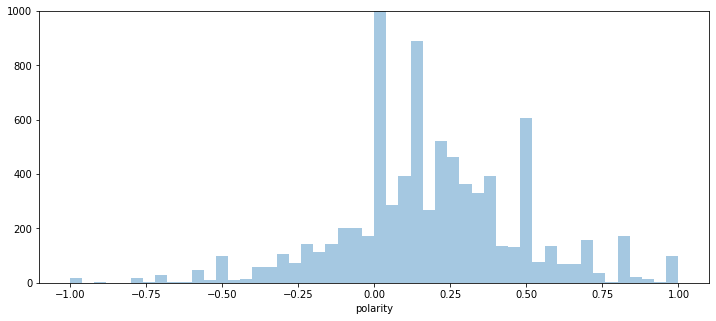

In [30]:
fig = plt.figure(figsize=(12,5))
sns.distplot(df['polarity'],kde = False)
plt.ylim(0, 1000)

In [43]:
df[df['polarity']<-0.8]['Text'][3101]

'The Invisible Man what a movie but tho terrifying #whatmovieareyouseeing #StayHome #RecommendaMovie'

In [32]:
# Sentiment 
df.groupby('sentiment').Text.count()

sentiment
negative    1532
neutral     4198
positive    5867
Name: Text, dtype: int64

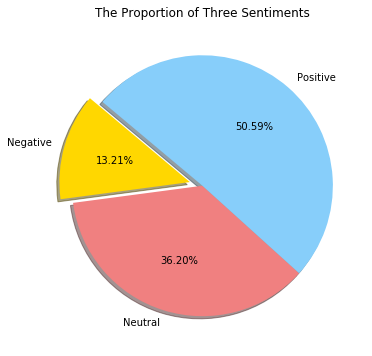

In [33]:
# draw a pie chart to show the ratio of 'Negative', 'Neutral' and 'Positive' tweets
fig = plt.figure(figsize=(6,6))
labels = 'Negative', 'Neutral', 'Positive'
sizes = df.groupby('sentiment').Text.count().values
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0) 

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.2f%%', shadow=True, startangle=140)
plt.title('The Proportion of Three Sentiments')
plt.show()

Text(0.5, 1.0, 'Average sentiment of Tweets across Dates')

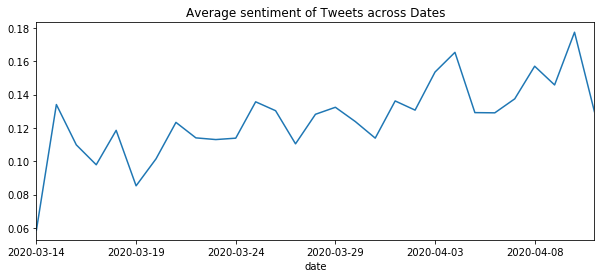

In [34]:
# plot sentiment fluctuation with date
fig, ax1 = plt.subplots(figsize=(10,4))
df.groupby(['date']).mean()['polarity'].plot(kind = 'line')
plt.title('Average sentiment of Tweets across Dates')


# Word Clouds

In [59]:
# Create word frequency count
num_words = 300
word2count = {}
for i in tqdm(range(len(df['text_nlp']))): 
    for word in df['text_nlp'].iloc[i].split():
        if word not in word2count.keys(): 
            word2count[word] = 1
        else: 
            word2count[word] += 1
            
freq_words = heapq.nlargest(num_words, word2count, key=word2count.get)


100%|██████████| 11597/11597 [00:00<00:00, 39932.21it/s]


In [46]:
from wordcloud import WordCloud, ImageColorGenerator
from os import path, getcwd
from PIL import Image
d = getcwd()
mask = np.array(Image.open(path.join(d,'twitter.png')).convert("RGB"))
color = np.array(Image.open(path.join(d,'color.png')).convert("RGB"))

def func(arr):   
    if(arr[2]==0):
        return np.array([255,255,255],dtype="uint8")
    else:
        return arr

mask=np.apply_along_axis(func, 2, mask)
color=np.apply_along_axis(func, 2, color)

In [47]:
red = np.array(Image.open(path.join(d,'red.png')).convert("RGB"))
red=np.apply_along_axis(func, 2, red)

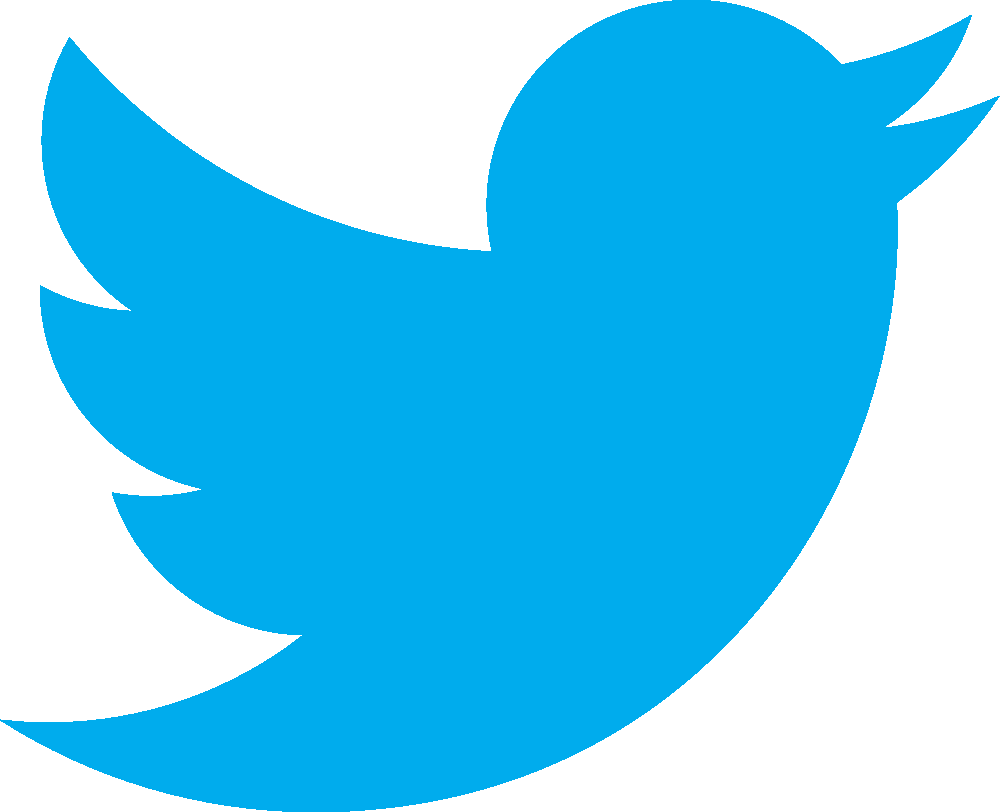

In [88]:
Image.fromarray(mask,"RGB")

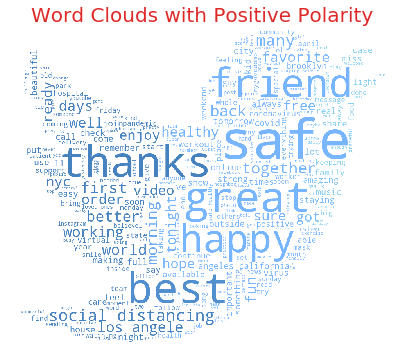

In [62]:
wordcloud = WordCloud(width=600, height=500, random_state=1, max_words=num_words, 
                          min_font_size=10,  max_font_size=140,
                          background_color='white',stopwords=set(STOPWORDS),mask = mask)
wordcloud.generate(str(set(df['text_nlp'][df['sentiment'] == 'positive'])))
    # declare our figure  
image_colors = ImageColorGenerator(color)
plt.figure(figsize=(7,6))
plt.title("Word Clouds with Positive Polarity", fontsize=20,color='#DE2929')
plt.imshow(wordcloud, interpolation='bilinear')
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='None')
plt.axis('off')
plt.show()

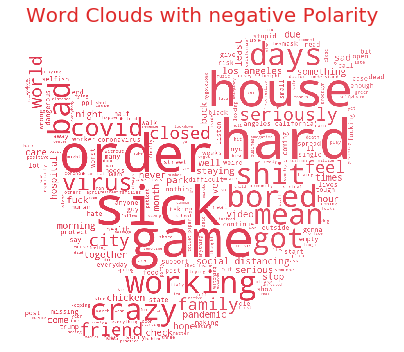

In [113]:
wordcloud = WordCloud(width=600, height=500, random_state=1, max_words=num_words, 
                          min_font_size=10,  max_font_size=140,
                          background_color='white', stopwords=set(STOPWORDS),mask = mask)
wordcloud.generate(str(set(df['text_nlp'][df['sentiment'] == 'negative'])))
    # declare our figure  
image_colors = ImageColorGenerator(red)
plt.figure(figsize=(7,6))
plt.title("Word Clouds with negative Polarity", fontsize=20,color='#DE2929')
plt.imshow(wordcloud, interpolation='bilinear')
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='None')
plt.axis('off')
plt.show()

In [114]:
wordcloud.to_file('negative1.png')

In [61]:
add_stopwords = ['day','like','go','one','today','let','get',
 '2', '1','3','4','5','take','make','think','want','way',
'see','still', 'via', 'now','much', 'even','watch','क',
 'all','really','thing', 'every','around','here','made',
 'also','part','total', 'things',  'little','getting',
 'last','essential','long', 'another', 'look', 'next','there',
 'people','time','new','thank','need','good','going','know',
 'week','everyone','live','love','right','home','us','stay','re',
'help', 'work', 'quarantine', 'life', 'keep', 'york', "york'", 'don']

# Add meaningless words into stopwords
for i in range(len(add_stopwords)):
    STOPWORDS.add(add_stopwords[i])

# Topic Modeing

### preprocessing for Topic Modeling

In [40]:
# tokenize each sentence into a list of words, removing punctuations
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['text_nlp']))

# Remove Stop and common Words
stopwords = nltk.corpus.stopwords.words('english')
# 'home', 'stay','new','york', 'time',
newStopWords =  ['s','t',  'm', 're','don','ve','2', '3', '1', 
                 'it', 'i', 'us', 'get', 'you', 'let', 'going', 'know', 
                'make', 'take', 'still','got', 'can', 'this', 'all', 'me','go',
                'even', 'here', 'well', 'much', 'many', 'way', 'want', 'every', 'little']
stopwords.extend(newStopWords)

data_words = [[word for word in doc if word not in stopwords] for doc in data_words]

In [41]:
# restrict words to only noun, adjective, verb and adverb
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [42]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

## Finding the optimal number of topics using LdaMallet model

In [43]:
start=24
limit=32
step=2
random = 155

In [44]:
# Write the function to compute coherence values for each model. 
# This could help us choose how many topics should be included into our model.

def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,random_seed=random)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [45]:
# compute coherence values for each model
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

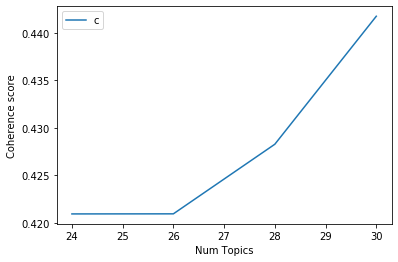

In [46]:
# plot the coherence values when number of topics equals to different numbers
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [47]:
# plot the coherence values when number of topics equals to different numbers
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 24  has Coherence Value of 0.4209
Num Topics = 26  has Coherence Value of 0.4209
Num Topics = 28  has Coherence Value of 0.4283
Num Topics = 30  has Coherence Value of 0.4418


### Finding Key Words for each topic  using optimal LdaMallet model

In [48]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus,
                                             num_topics=30, 
                                             id2word=id2word,
                                             random_seed = 155)

In [49]:
# Show Topics
model_topics = ldamallet.show_topics(formatted=False)
pprint(sorted(ldamallet.print_topics(num_words=8)))

[(0,
  '0.063*"wait" + 0.051*"walk" + 0.038*"beautiful" + 0.028*"smile" + '
  '0.027*"pretty" + 0.026*"staff" + 0.025*"city" + 0.021*"neighborhood"'),
 (3,
  '0.200*"time" + 0.152*"friend" + 0.124*"family" + 0.031*"grateful" + '
  '0.030*"lose" + 0.026*"neighbor" + 0.026*"spend" + 0.019*"difficult"'),
 (4,
  '0.093*"essential" + 0.073*"worker" + 0.069*"care" + 0.047*"health" + '
  '0.045*"leave" + 0.036*"risk" + 0.030*"job" + 0.019*"healthcare"'),
 (5,
  '0.095*"back" + 0.086*"great" + 0.060*"read" + 0.033*"weekend" + '
  '0.030*"finally" + 0.027*"end" + 0.026*"normal" + 0.026*"exercise"'),
 (7,
  '0.149*"life" + 0.091*"social" + 0.054*"distancing" + 0.053*"practice" + '
  '0.050*"save" + 0.041*"fight" + 0.041*"distance" + 0.024*"doctor"'),
 (8,
  '0.217*"love" + 0.057*"send" + 0.051*"hand" + 0.033*"light" + 0.025*"prayer" '
  '+ 0.024*"color" + 0.024*"wash" + 0.024*"forget"'),
 (9,
  '0.094*"case" + 0.055*"death" + 0.042*"state" + 0.040*"continue" + '
  '0.037*"covid" + 0.033*"test" +

In [50]:
topics = pd.DataFrame(sorted(ldamallet.print_topics(num_words=10)))
topics.columns = ['Topic_num','Key_words']
topics.to_csv('30_topics_2.csv',index = False)

In [51]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.44176626000294755


In [52]:
topic_names = ['beautiful/smile/pretty/staff',
 'mask/face/wear',
 'time/week/remember/ago',
 'friend/family/grateful/neighbor',
 'worker/care/health/risk',
 'read/weekend/exercise/book',
 'home/stay/calm/connected',
 'social/distancing/save/doctor',
 'love/prayer/hand/wash',
 'case/death/state/test',
 'watch/video/share/youtube',
 'free/place/donate',
 'spread/important/news/high',
 'stay/safe/home/healthy',
 'virus/big/happen/break',
 'work/hard/hospital/patient/bed',
 'kid/virtual/class/school',
 'quarantine/isolation',
 'community/pandemic/protect/reminder',
 'good/feel/world/moment/photo',
 'tonight/tomorrow/night',
 'people/die/sick',
 'word/message/picture',
 'play/happy/music/game',
 'challenge/workout/fresh/air',
 'food/eat/house/clean',
 'amazing/dinner/cook',
 'show/favorite/movie',
 'order/call/online/delivery',
 'close/business/public/park']

# Topic Vector

In [79]:
topics_docs = []
for m in ldamallet[corpus]:
    topics_docs.append(m)

train_vecs = []
for i in topics_docs:
    topic_vec = [j[1] for j in i]
    train_vecs.append(topic_vec) 

topic_dis = pd.DataFrame(train_vecs,columns=topic_names)
topic_dis.head()

df= pd.concat([df,topic_dis],axis = 1)
df.head(2)

,User,Text,Retweets,Favorites,HashTags,City,date,time,text_nlp,text_len,...,tonight/tomorrow/night,people/die/sick,word/message/picture,play/happy/music/game,challenge/workout/fresh/air,food/eat/house/clean,amazing/dinner/cook,show/favorite/movie,order/call/online/delivery,close/business/public/park
0,BalloonSaloon,Thankfully there is still always much to celeb...,0.0,0.0,#memories #coronapocalypse #nyc #coronavirus #...,New York,2020-04-11,23-54-18,thankfully still always much celebrate,66.0,...,0.032051,0.032051,0.032051,0.032051,0.044872,0.032051,0.032051,0.032051,0.032051,0.032051
1,Andros1975,When you want a hot pocket and you are not all...,0.0,0.0,#HomeMade #HotPockets #StayHome #StayHome #Sta...,New York,2020-04-11,23-45-03,want hot pocket allowed go store silver towers...,101.0,...,0.039683,0.029762,0.029762,0.029762,0.029762,0.029762,0.047619,0.047619,0.029762,0.029762


# Word Vector

In [71]:
# Creat all the interested word for analysis
Interesting_words = ['tv','reading','video','game','drinking','puzzle','beach','eating','walking',
                 'tiktok','music','spotify','talk','gym','exercise','phone','zoom',
                'talk','eat','youtube','netflix','watch','episode','workout','challenge',
                 'listen','song','park','beach','reading',
                 'puzzle','sleeping','sleep','instagram','ins','virtual',
                 'lunch','breakfast','dinner','cooking','working',
                 'social','friends','friend','family','kids','delivery','wine']

In [72]:
for col in Interesting_words:
    StayHome[col]=StayHome.text_nlp.apply(lambda x: int(col in str(x)))

## City Vector

In [73]:
# get all the cities
city = list(StayHome['City'].unique())

In [74]:
city.remove(np.nan)

In [75]:
# create city vector
for col in city:
    StayHome[col]=StayHome.City.apply(lambda x: int(str(x) == col))
StayHome = StayHome.drop('Houston',1)
StayHome = StayHome.dropna()

# Sentiment Score

In [76]:
# create polarity score and subjectivity score
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

StayHome['Text'] = StayHome['Text'].apply(str)
StayHome['polarity'] = StayHome['Text'].apply(pol)
StayHome['subjectivity'] = StayHome['Text'].apply(sub)

# Lasso Regression

In [60]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [61]:
# run a lasso regression on all the variables and polarity
X = StayHome.drop(['User', 'Text', 'Retweets', 'Favorites', 'HashTags','date','City',
       'time', 'text_nlp', 'text_len', 'word_count','polarity','subjectivity'], 1)
Y = StayHome['polarity']

In [62]:
# train test split
X_test,X_train,y_test,y_train=train_test_split(X,Y, test_size=0.3, random_state=31)

In [63]:
# run lassocv
lasso = LassoCV(cv=10, random_state=0)
lasso.fit(X_train, y_train)

ValueError: could not convert string to float: 'positive'

In [ ]:
# predict y
Y_pred = lasso.predict(X_test)

In [ ]:
# performance
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
print(train_score)
print(test_score)

In [ ]:
# create a dictionary with feature and coeficient
coef_dict = dict(zip(list(X.columns),list(list(lasso.coef_))))
# rank feature by coeficient value
import operator
sorted_importance = sorted(coef_dict.items(), key=operator.itemgetter(1))
sorted_importance

# Topic Modeling Ananlyais

In [80]:
topic_list = df.columns[13:43]
topic_mean = df.iloc[:,13:43].mean().values

for i in range(len(topic_list)):
    df[i] = np.where(df[topic_list[i]] > 0.08,1,0)
    
topic_polarity = list()
for i in range(30):
    topic_polarity.append(df[df[i]==1]['polarity'].mean())
    
topic_polarity = pd.DataFrame({'Topics':topic_list,'Polarity':topic_polarity})
topic_polarity.sort_values(by = ['Polarity'],ascending=False)

,Topics,Polarity
10,watch/video/share/youtube,0.194402
7,social/distancing/save/doctor,0.185027
11,free/place/donate,0.184615
20,tonight/tomorrow/night,0.175014
29,close/business/public/park,0.171233
8,love/prayer/hand/wash,0.164978
22,word/message/picture,0.163660
4,worker/care/health/risk,0.147788
23,play/happy/music/game,0.147143
28,order/call/online/delivery,0.146349


In [81]:
# count how much time each topic is discussed in each city
topic_cities = df.groupby(['City']).sum().iloc[:,-30:].transpose()

# Single-word analysis

In [82]:
df = df.dropna(subset = ['text_nlp'])

In [83]:
specail_words = ['video','netflix','watch','episode','movie',
                 'gym','exercise','workout','air','fresh',
                 'listen','music','song',
                 'sleeping',
                 'prayer',
                 'reading','book',
                 'game',
                 'instagram',
                 'phone','zoom','virtual','message',
                 'eat','lunch','breakfast','dinner','cooking',
                 'friends','friend','family','neighbor',
                 'delivery',
                 'drinking','wine']
avg_polarity = list()
num_texts = list()
for word in specail_words:
    avg_polarity.append(df[df['text_nlp'].str.match(word)]['polarity'].mean())
    num_texts.append(len(df[df['text_nlp'].str.match(word)]))

In [84]:
activity = pd.DataFrame()
activity['activity'] = specail_words
activity['avg_polarity'] = avg_polarity
activity['num_texts'] = num_texts
activity= activity.sort_values(by = ['avg_polarity'],ascending = True)
activity.reset_index(inplace = True)
activity.drop('index',axis = 1,inplace = True)

In [85]:
positive = activity[activity['avg_polarity']>0.2].index
mild = activity[(activity['avg_polarity']>0) &(activity['avg_polarity']<=0.2)].index

Text(0.5, 1.0, 'The average polarity of all Tweets containing a keyword')

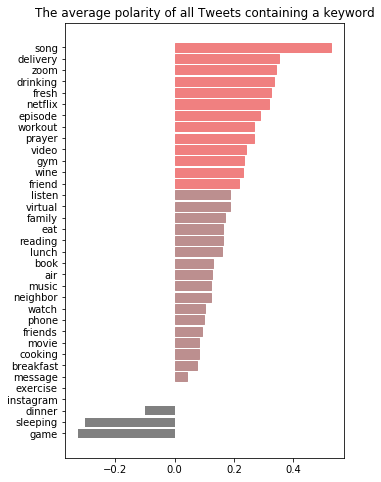

In [88]:
fig, ax = plt.subplots(figsize=(5,8))
barlist =plt.barh(range(len(activity['avg_polarity'])), activity['avg_polarity'],color = 'grey')
ax.set_yticks(range(len(activity['avg_polarity'])))
ax.set_yticklabels(activity['activity'])
plt.rc('xtick', labelsize=10) 
for word in positive:
    barlist[word].set_color('lightcoral')
for word in mild:
    barlist[word].set_color('rosybrown')
plt.title('The average polarity of all Tweets containing a keyword')